In [63]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

In [64]:
#kinematic viscosity curve fit:
dataframe = pd.read_csv("./data/models_data/Viscosity_data.csv",sep=";")
dataframe = dataframe[["emp. [°C]","Kin. Viscosity [mm²/s]","Density [g/cm³]"]].dropna()
poly = np.polyfit(dataframe["emp. [°C]"],dataframe["Kin. Viscosity [mm²/s]"], deg=5)
print(np.polyval(poly, 13.1795)) #returns the v (kinematic viscosity of water) of 5C°

1.1953406700143954


In [65]:
LakeAegeri= pd.read_csv(r".\data\cleaned_data\230422\230422_LakeAegeri_3A.csv")
try:
    LakeAegeri=LakeAegeri.drop(["Unnamed: 0"], axis=1)
except:
    pass
LakeAegeri["datetime"] = pd.to_datetime(LakeAegeri["datetime"])
LakeAegeri.columns

Index(['x', 'datetime', 'bulk_temp', 'skin_temp', 'air_temp', 'wind_speed',
       'air_pressure', 'relative_humidity', 'solar_irradiance',
       'meteo_timestamp', 'Quality'],
      dtype='object')

In [66]:
LakeAegeri["Conductivity"] = 172  #we dont have the data here. later...
LakeAegeri.head()


def skin_effect(dataframe, column_watertemp, column_windspeed, column_solar_irradiance, column_conductivity,
                variance=6):
    #see above
    dataframe_viscos = pd.read_csv("./data/models_data/Viscosity_data.csv", sep=";")
    dataframe_viscos = dataframe_viscos[["emp. [°C]", "Kin. Viscosity [mm²/s]", "Density [g/cm³]"]].dropna()
    poly = np.polyfit(dataframe_viscos["emp. [°C]"], dataframe_viscos["Kin. Viscosity [mm²/s]"], deg=5)

    dataframe["kin_Viscosity"] = np.polyval(poly, dataframe[column_watertemp])
    #thikness_of_molecular_sublayer=(variance*dataframe["kin_Viscosity"])/dataframe[column_windspeed]

    delta_t = (variance * dataframe[column_solar_irradiance] * dataframe["kin_Viscosity"]) / (
                dataframe[column_conductivity] * dataframe[column_windspeed])
    return pd.concat([pd.DataFrame(delta_t), dataframe], axis=1).rename(columns={0: "skin_effect_pred"})


result = skin_effect(dataframe=LakeAegeri, column_watertemp="bulk_temp", variance=4, column_windspeed="wind_speed",
                     column_solar_irradiance="solar_irradiance", column_conductivity="Conductivity")


In [67]:
#Test the model:
result["Skin_effect_real"]=(result["bulk_temp"]-result["skin_temp"]).abs()

display(result["skin_effect_pred"].describe())


count    14991.000000
mean         1.048880
std          2.725719
min          0.000000
25%          0.000000
50%          0.006085
75%          0.723538
max         48.991702
Name: skin_effect_pred, dtype: float64

In [68]:
import numpy as np

def calculate_real_skin_effect(dataframe, column_watertemp, column_windspeed, column_solar_irradiance, column_conductivity):
    # Define the possible values for variance
    saunders_values = [x * 0.1 for x in range(10, 91)]  # Variance values from 1 to 9 in 0.1 steps
    # Initialize variables to keep track of the best variance value and minimum difference
    skin_effect_pred = []
    skin_effect_real = []
    skin_effect_difference=[]
    dataframe_viscos = pd.read_csv("./data/models_data/Viscosity_data.csv", sep=";")
    dataframe_viscos = dataframe_viscos[["emp. [°C]", "Kin. Viscosity [mm²/s]", "Density [g/cm³]"]].dropna()
    poly = np.polyfit(dataframe_viscos["emp. [°C]"], dataframe_viscos["Kin. Viscosity [mm²/s]"], deg=5)
    dataframe["kin_Viscosity"] = np.polyval(poly, dataframe[column_watertemp])

    for saunders_val in saunders_values:
        # Calculate delta_t using the formula
        delta_t = (saunders_val * dataframe[column_solar_irradiance] * dataframe["kin_Viscosity"]) / (
                dataframe[column_conductivity] * dataframe[column_windspeed])
        skin_effect_pred.append(delta_t.mean())

        # Calculate the real skin effect using your specific formula (not provided in the question)
        real_skin_effect = np.abs(dataframe[column_watertemp] - dataframe["skin_temp"])  # Replace with your real skin effect formula
        skin_effect_real.append(real_skin_effect.mean())

        # Calculate the difference between the real skin effect and delta_t
        difference = np.abs(real_skin_effect - delta_t)
        skin_effect_difference.append(difference.mean())
        # Check if the current difference is smaller than the minimum difference

    result_list=(skin_effect_pred[i] -  skin_effect_real[i] for i in range(len(skin_effect_real)))
    result_list=[abs(i) for i in result_list]
    index_result=result_list.index(min(list(result_list)))

    return saunders_values[index_result]


optimal_variance = calculate_real_skin_effect(dataframe=result, column_watertemp="bulk_temp", column_windspeed="wind_speed", column_solar_irradiance='solar_irradiance', column_conductivity="Conductivity")

LakeAegeri=skin_effect(LakeAegeri, column_watertemp="bulk_temp", column_windspeed="wind_speed", column_solar_irradiance='solar_irradiance', column_conductivity="Conductivity",variance=optimal_variance)

LakeAegeri["skin_effect_real"]=(LakeAegeri["bulk_temp"]-LakeAegeri["skin_temp"]).abs()


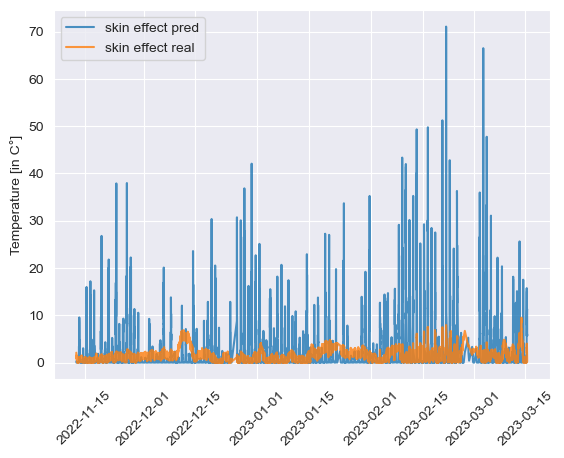

In [74]:
plt.plot(LakeAegeri["datetime"],LakeAegeri["skin_effect_pred"],label="skin effect pred",alpha=0.8)
plt.plot(LakeAegeri["datetime"],LakeAegeri["skin_effect_real"],label="skin effect real",alpha=0.8)
plt.legend()
plt.ylabel("Temperature [in C°]")
plt.xticks(rotation=45)
plt.show()